[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (2, 7), (3, 5), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (4, 5), (4, 6), (4, 28), (4, 29), (4, 30), (4, 31), (5, 6), (5, 7), (6, 7), (6, 10), (6, 12), (6, 18), (6, 22), (6, 25), (6, 29), (7, 14), (7, 30), (7, 58), (7, 71), (7, 85), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 20), (8, 21), (8, 22), (8, 23), (8, 24), (8, 26), (8, 27), (8, 32), (

<ipython-input-1-c1130a03aae9>:353: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)


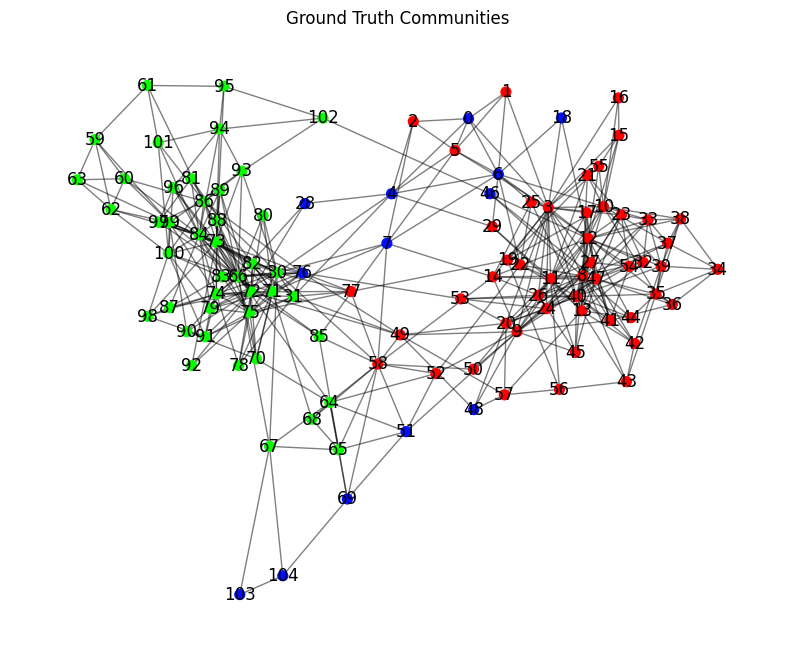

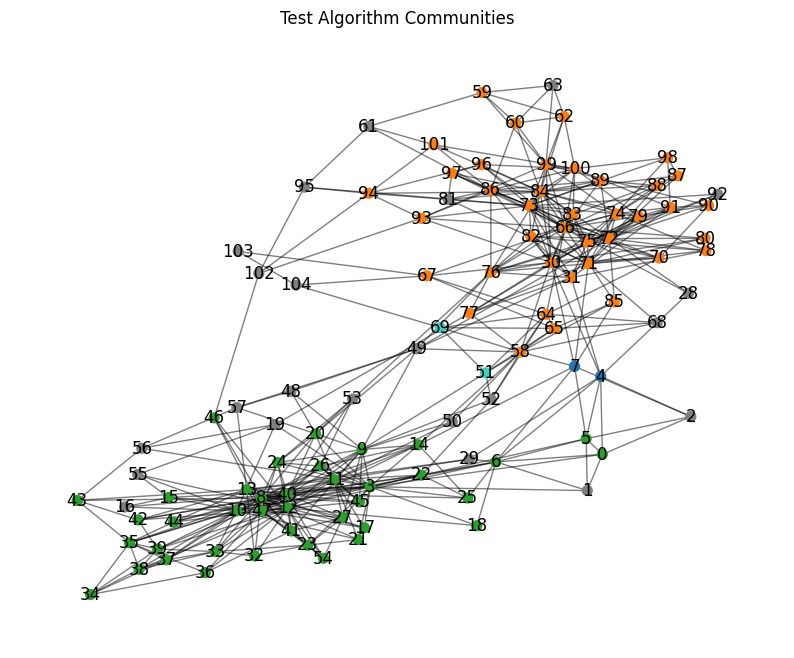

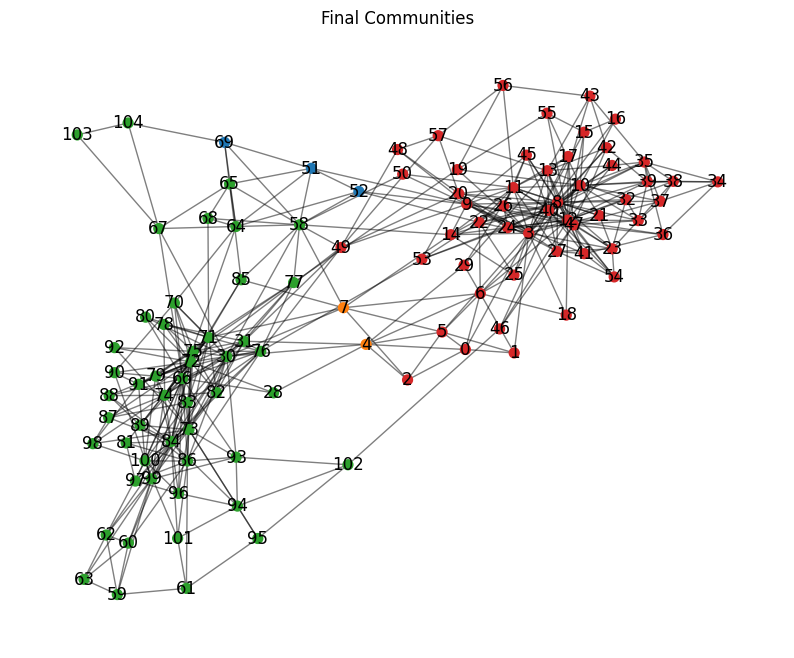

Calculating best minimal value for power law fit
Power-law vs Exponential: R = -67.82872029356135, p = 4.497775985417848e-05
Power-law vs Lognormal: R = -84.80100698739733, p = 1.4424409115023885e-18


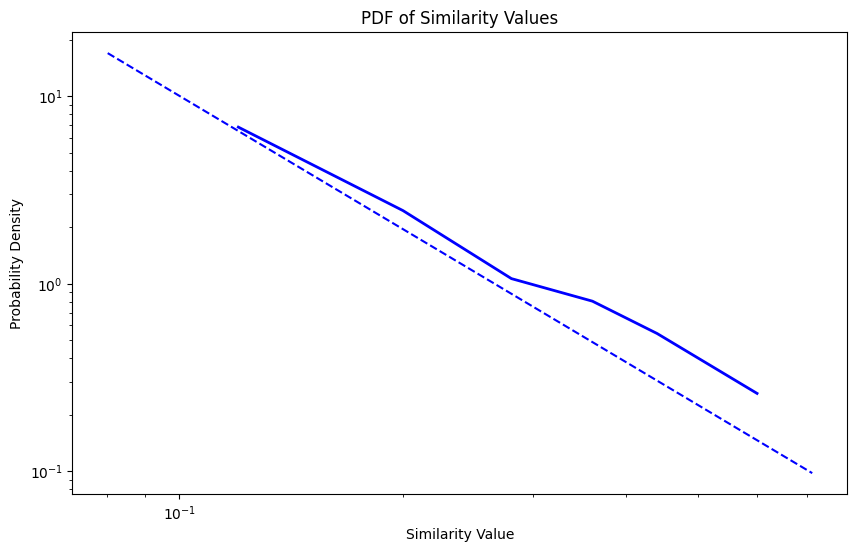

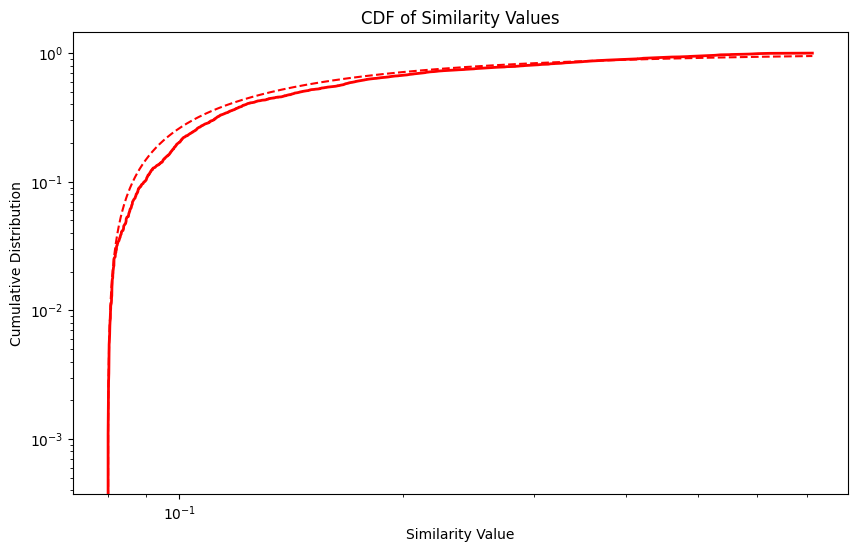

Power-law exponent (alpha): 2.3597418721331898
Standard error in the fitted exponent (sigma): 0.031681932078283355
Standard error in the fitted exponent (sigma): 0.031681932078283355


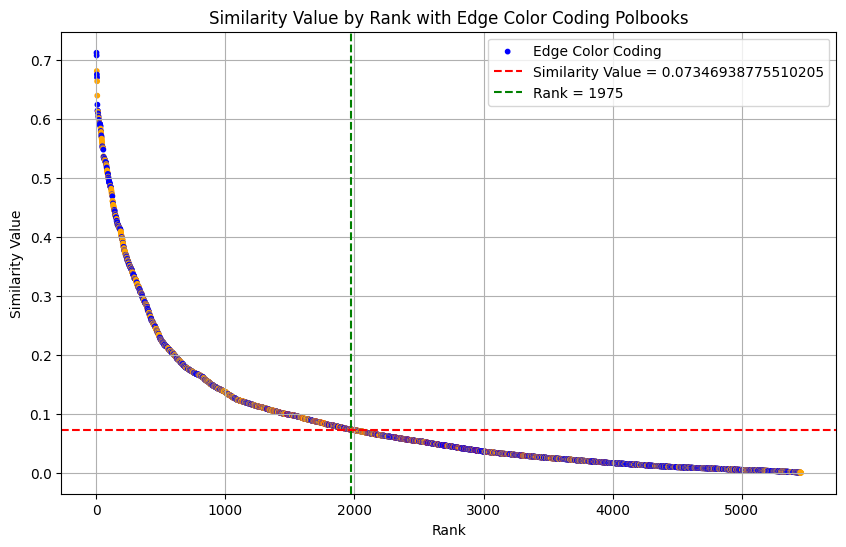

[(0, 2), (0, 4), (1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (2, 7), (4, 29), (7, 58), (14, 58), (15, 16), (15, 55), (19, 55), (19, 56), (19, 77), (20, 48), (20, 57), (22, 52), (28, 66), (28, 72), (43, 56), (46, 47), (46, 102), (48, 49), (48, 57), (49, 57), (49, 58), (50, 58), (52, 58), (52, 64), (53, 76), (56, 57), (59, 61), (59, 63), (61, 95), (61, 101), (67, 103), (67, 104), (68, 71), (69, 104), (87, 98), (93, 102), (94, 102), (95, 102), (103, 104)]
Percentage of edges in G that are also in edges_in_G: 10.43%


In [ ]:
!pip install powerlaw
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
import urllib.request
import io
import zipfile
import copy
import powerlaw

def merge_small_communities(G, initial_communities, lambda_threshold =3):
    # Step 1: Classify communities based on size
    small_communities = [set(c) for c in initial_communities if len(c) < lambda_threshold]
    large_communities = [set(c) for c in initial_communities if len(c) >= lambda_threshold]

    # For each small community, find the best large community to merge into
    for small_community in small_communities:
        best_total_similarity = 0
        best_large_community_index = None

        # Calculate total similarity of each small community node with nodes in each large community
        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for node in small_community:
                for neighbor in G.neighbors(node):
                    if neighbor in large_community:
                        n_u = set(G.neighbors(node)) | {node}
                        n_v = set(G.neighbors(neighbor)) | {neighbor}
                        intersection = len(n_u & n_v)
                        union = len(n_u | n_v)
                        similarity = float(intersection) / union if union != 0 else 0
                        total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # Merge the small community into the best matching large community
        if best_large_community_index is not None:
            large_communities[best_large_community_index] = large_communities[best_large_community_index].union(small_community)

    # Combine all communities after merging
    final_communities = large_communities + [c for c in small_communities if len(c) >= lambda_threshold]

    # Convert sets back to lists for consistency
    final_communities = [list(community) for community in final_communities]

    return final_communities


def find_most_similar_node_pairs_iterative(similarity_matrix):
    current_similarity_matrix = copy.deepcopy(similarity_matrix)
    num_nodes = current_similarity_matrix.shape[0]

    # Initialize a dictionary to store results based on similarity values
    similar_pairs_dict = {}
    s = set()
    while (len(s) < num_nodes):
        # Find the indices of the maximum similarity value in the entire matrix
        i, j = np.unravel_index(np.argmax(current_similarity_matrix, axis=None), current_similarity_matrix.shape)
        similar_pair = (i, j)
        s.add(i)
        s.add(j)
        similar_value = current_similarity_matrix[i, j]

        # Exclude the current pair by setting its similarity to -inf
        current_similarity_matrix[i, j] = -np.inf

        # Append the result to the dictionary based on similarity value
        if similar_value not in similar_pairs_dict:
            similar_pairs_dict[similar_value] = []

        similar_pairs_dict[similar_value].append(similar_pair)

    # # # Print and return the results
    # for value, pairs in similar_pairs_dict.items():
    #     for idx, pair in enumerate(pairs):
    #          print(f"Similar Pair with Value {value}, Index {idx + 1}: {pair}")

    return similar_pairs_dict





def form_initial_communities(G, result_matrix, lambda_threshold=2, similarity_threshold=0.15):
    num_nodes = result_matrix.shape[0]
    communities = [[node] for node in range(num_nodes)]  # Initially, each node is in its own community
    edges_in_G = []  # List to hold edges present in G and set to zero
    edges_not_in_G = []  # List to hold edges not present in G and set to zero
    # Create a new similarity matrix with updated values
    updated_similarity_matrix = result_matrix.copy()
    zero_count = 0  # Counter for zero entries

    for i in range(num_nodes):
        for j in range(i+1,num_nodes):  # Consider upper triangular matrix to avoid repetition
            if result_matrix[i, j] < similarity_threshold:
                updated_similarity_matrix[i, j] = 0
                updated_similarity_matrix[j, i] = 0  # Symmetric update
                if G.has_edge(i, j) or G.has_edge(j, i):
                    edges_in_G.append((i, j))
                else:
                    edges_not_in_G.append((i, j))

    # Calculate the total number of node pairs
    # total_pairs = num_nodes * num_nodes
    # print(zero_count)

    # Calculate the percentage of node pairs assigned zero
    # zero_percentage = (zero_count / total_pairs) * 100

    # # Print the new similarity matrix
    # print("New Similarity Matrix:")
    # for row in updated_similarity_matrix:
    #     print(list(row))

    while True:
        # Find the pair of communities with the highest average similarity score
        max_avg_similarity = 0
        max_community_pair = None

        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                community_i = communities[i]
                community_j = communities[j]

                total_similarity = 0
                num_nodes_i = len(community_i)

                for u in community_i:
                    node_similarity_sum = sum(updated_similarity_matrix[u, v] for v in community_j)
                    node_avg_similarity = node_similarity_sum / len(community_j)
                    total_similarity += node_avg_similarity
                total_similarity /= num_nodes_i

                if total_similarity > max_avg_similarity:
                    max_avg_similarity = total_similarity
                    max_community_pair = (i, j)


        if max_community_pair is None:
            break  # No more communities to merge

        if max_avg_similarity < similarity_threshold:
                    break
        # Merge the communities with the highest average similarity score
        i, j = max_community_pair
        merged_community = communities[i] + communities[j]
        communities.pop(j)
        communities.pop(i)
        communities.append(merged_community)
        # print(zero_percentage)
        # Check if all remaining communities have at least the specified threshold
        if min(len(community) for community in communities) >= lambda_threshold:
            break



    return updated_similarity_matrix, edges_in_G, edges_not_in_G,communities


def matrix_operation(A, S, G):  # Assuming G is your graph
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    n = num_edges / num_nodes  # Calculate n as the number of nodes divided by the number of edges

    # Calculate S^n
    S_power_n = np.linalg.matrix_power(S, int(n))

    # Perform A * S^n
    result = np.dot(A, S_power_n)
    return result


def normalized_coefficients(jaccard_matrix):
    # Initialize an empty matrix of the same shape as the jaccard_matrix
    normalized_matrix = np.zeros(jaccard_matrix.shape)

    # Iterate over each row in the jaccard_matrix
    for i in range(jaccard_matrix.shape[0]):
        row_sum = np.sum(jaccard_matrix[i, :])  # Calculate the sum of the current row
        if row_sum > 0:  # Avoid division by zero'
            normalized_matrix[i, :] = jaccard_matrix[i, :] / row_sum
            nsum = np.sum(normalized_matrix[i, :])  # Normalize the row by its sum
    # checks if the sum of each row is 1
    # for i in range(normalized_matrix.shape[0]):
    #     row_sum = np.sum(normalized_matrix[i, :])
    #     print(f"Sum of row {i}: {row_sum}")
    print("---------------------Normalized Jaccard Matrix------------------")
    print(normalized_matrix)
    return normalized_matrix


def get_jaccard_coefficients(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v:  # Ensure we're not comparing a node with itself
                n_u = set(G[u])  # Neighbors of u
                n_v = set(G[v])  # Neighbors of v
                intersection = len(n_u & n_v)
                union = len(n_u | n_v)
                adjacency_matrix[u, v] = float(intersection) / (union) if union != 0 else 0
    print("-----------------Jaccard Matrix---------------")
    print(adjacency_matrix)
    return adjacency_matrix


def get_adjacency_matrix(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if G.has_edge(i, j):
                adjacency_matrix[i, j] = 1
            else:
                adjacency_matrix[i, j] = 0
    print("--------------------Adjacency Matrix------------------")
    print(adjacency_matrix)
    return adjacency_matrix


url = "https://websites.umich.edu/~mejn/netdata/polbooks.zip"

sock = urllib.request.urlopen(url)
s = io.BytesIO(sock.read())
sock.close()

zf = zipfile.ZipFile(s)
gml = zf.read("polbooks.gml").decode()

# Parse GML data
gml = gml.split("\n")[1:]
G = nx.parse_gml('\n'.join(gml))

# Convert node labels to integers
mapping = dict(zip(G.nodes(), range(len(G.nodes()))))
G = nx.relabel_nodes(G, mapping)

print(G.nodes())
print(G.edges())



books_truth = [2,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,
              0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,1,1,1,1,1,1,1,
              1,1,1,2,1,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,1,1,
              1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2]





Adjancency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)
# print(A)
print(jaccard_coefficients)
print(jaccard_normalized)
# Optionally, print the Jaccard coefficients
markov_similarity_enhancement_matrix = matrix_operation(Adjancency, jaccard_normalized, G)
print(markov_similarity_enhancement_matrix)
result_list = find_most_similar_node_pairs_iterative(markov_similarity_enhancement_matrix)
updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.07346938775510205)
# initial_communities = form_initial_communities(markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.0653061224489796)
final_communities = merge_small_communities(G, initial_communities,lambda_threshold=2)

print("----------------------------Initial Community----------------------------------")
for i, community in enumerate(initial_communities):
    print(f"Community {i + 1}: {community}")

print("-----------------------------Final Community-----------------------------------")
for i, community in enumerate(final_communities):
    print(f"Final Community {i + 1}: {community}")


def create_sets_based_on_membership(G, books_truth):
    membership_sets = {}  # Dictionary to store sets of nodes for each ground truth membership

    for node, membership in enumerate(books_truth):
        if membership not in membership_sets:
            membership_sets[membership] = set()

        membership_sets[membership].add(node)

    return membership_sets

# # Create sets based on ground truth membership
membership_sets = create_sets_based_on_membership(G, books_truth)

print("------------------------Sets based on Ground Truth Membership-------------------")
for membership, node_set in membership_sets.items():
     print(f"Ground Truth Membership: {membership}, Nodes: {node_set}")


print("Modularity",nx.community.quality.modularity(G, final_communities))

num_nodes = G.number_of_nodes()


predicted_labels = np.zeros(num_nodes, dtype=int)
for idx, community in enumerate(final_communities):
    for node in community:
        predicted_labels[node] = idx
print("Predicted Labels:", predicted_labels)
print(books_truth)
nmi_score_binary_matrix = normalized_mutual_info_score(books_truth, predicted_labels)

print("NMI Score", nmi_score_binary_matrix)

def plot_communities(G, communities, title):
    # Manually define a list of colors for the communities
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf","#00b2fe","#39D2C0"
    ]
    # This list can be extended with more colors if needed

    # Assign a color to each community, grey for communities of size 1
    community_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if len(community) == 1:
                community_colors[node] = "grey"  # Grey color for communities of size 1
            else:
                # Use modulo to cycle through the color list if there are more communities than colors
                community_colors[node] = colors[i % len(colors)]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[community_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_groundtruth_communities(G, membership_sets):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)

    # Assign a color to each ground truth membership
    membership_colors = {node: color_map(membership) for membership, nodes in membership_sets.items() for node in nodes}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[membership_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title("Ground Truth Communities")
    plt.axis('off')
    plt.show()
# Example usage:
# Plot the initial communities
membership_sets = create_sets_based_on_membership(G, books_truth)

# Plot the ground truth communities
plot_groundtruth_communities(G, membership_sets)

plot_communities(G, initial_communities, "Test Algorithm Communities")
#plot_communities(G, membership_sets, "Groundtruth Communites")
# Plot the final communities
plot_communities(G, final_communities, "Final Communities")

# similarity_thresholds = np.linspace(0, 0.1, 50)  # Adjust range and steps as needed
# modularity_values = []
# nmi_values = []

# Adjacency = get_adjacency_matrix(G)
# jaccard_coefficients = get_jaccard_coefficients(G)
# jaccard_normalized = normalized_coefficients(jaccard_coefficients)

# # Iterate over similarity thresholds
# for similarity_threshold in similarity_thresholds:
#     # Enhance similarity matrix and find communities

#     markov_similarity_enhancement_matrix = matrix_operation(Adjacency, jaccard_normalized, G)
#     updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=similarity_threshold)
#     final_communities = merge_small_communities(G, initial_communities, lambda_threshold=2)

#     # Calculate modularity
#     modularity = nx.community.quality.modularity(G, final_communities)
#     modularity_values.append(modularity)

#     # Calculate NMI
#     predicted_labels = np.zeros(G.number_of_nodes(), dtype=int)
#     for idx, community in enumerate(final_communities):
#         for node in community:
#             predicted_labels[node] = idx
#     nmi = normalized_mutual_info_score(books_truth , predicted_labels)
#     nmi_values.append(nmi)

# max_modularity_index = np.argmax(modularity_values)
# max_nmi_index = np.argmax(nmi_values)

# # Corresponding similarity thresholds
# similarity_threshold_with_max_modularity = similarity_thresholds[max_modularity_index]
# similarity_threshold_with_max_nmi = similarity_thresholds[max_nmi_index]

# # Maximum modularity and NMI values
# max_modularity = modularity_values[max_modularity_index]
# max_nmi = nmi_values[max_nmi_index]

# print("Maximum Modularity:")
# print("Similarity Threshold:", similarity_threshold_with_max_modularity)
# print("Modularity:", max_modularity)

# print("\nMaximum NMI:")
# print("Similarity Threshold:", similarity_threshold_with_max_nmi)
# print("NMI:", max_nmi)

# # Plot both Modularity and NMI values against similarity thresholds
# plt.plot(similarity_thresholds, modularity_values, label='Modularity')
# plt.plot(similarity_thresholds, nmi_values, label='NMI')
# plt.title('Modularity and NMI vs Similarity Threshold')
# plt.xlabel('Similarity Threshold')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


def analyze_similarity_distribution(similarities):
    # Fit the similarity values to a power-law distribution
    fit = powerlaw.Fit(similarities)

    # Compare the power-law distribution with an exponential distribution
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    # Compare the power-law distribution with a lognormal distribution
    R_lognorm, p_lognorm = fit.distribution_compare('power_law', 'lognormal')

    # Print the comparison results
    print(f"Power-law vs Exponential: R = {R_exp}, p = {p_exp}")
    print(f"Power-law vs Lognormal: R = {R_lognorm}, p = {p_lognorm}")

    # Plot the PDF and CDF
    plt.figure(figsize=(10, 6))
    figPDF = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=figPDF)
    plt.xlabel('Similarity Value')
    plt.ylabel('Probability Density')
    plt.title('PDF of Similarity Values')

    plt.figure(figsize=(10, 6))
    figCDF = fit.plot_cdf(color='r', linewidth=2)
    fit.power_law.plot_cdf(color='r', linestyle='--', ax=figCDF)
    plt.xlabel('Similarity Value')
    plt.ylabel('Cumulative Distribution')
    plt.title('CDF of Similarity Values')
    plt.show()

    # Get the parameters of the power law fit
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    print(f"Power-law exponent (alpha): {alpha}")
    print(f"Standard error in the fitted exponent (sigma): {sigma}")

    print(f"Standard error in the fitted exponent (sigma): {sigma}")

def plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    i_upper = np.triu_indices_from(markov_similarity_enhancement_matrix, k=1)
    similarities = markov_similarity_enhancement_matrix[i_upper]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]
    analyze_similarity_distribution(sorted_similarities)
    # Prepare color array
    colors = []
    for idx in range(len(sorted_indices)):
        i, j = np.unravel_index(i_upper[0][sorted_indices[idx]], markov_similarity_enhancement_matrix.shape)
        if (i, j) in edges_in_G or (j, i) in edges_in_G:
            colors.append('red')
        elif (i, j) in edges_not_in_G or (j, i) in edges_not_in_G:
            colors.append('orange')
        else:
            colors.append('blue')

    # Find the rank of the specified similarity value or the closest to it
    rank = np.searchsorted(sorted_similarities[::-1], similarity_value, side='left')
    # Adjust rank for 1-based indexing and for plotting (since we're using the sorted array in descending order)
    rank_adjusted = len(sorted_similarities) - rank

    ranks = np.arange(1, len(sorted_similarities) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ranks, sorted_similarities, c=colors, s=10, label='Edge Color Coding')
    plt.axhline(y=similarity_value, color='r', linestyle='--', label=f'Similarity Value = {similarity_value}')
    plt.axvline(x=rank_adjusted, color='g', linestyle='--', label=f'Rank = {rank_adjusted}')
    plt.xlabel('Rank')
    plt.ylabel('Similarity Value')
    plt.title('Similarity Value by Rank with Edge Color Coding Polbooks')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage, assuming markov_similarity_enhancement_matrix, G, edges_in_G, and edges_not_in_G are already defined
similarity_value = 0.07346938775510205  # Example similarity value
plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value)
print(edges_in_G)
def calculate_percentage_of_edges_in_G(G, edges_in_G):
    # Count the total number of edges in G
    total_edges_in_G = G.number_of_edges()

    # Count how many edges in the list are actually in G
    # Note: This step might be redundant if edges_in_G only contains edges from G,
    # but it's a safeguard in case edges_in_G contains more than that.
    edges_in_G_count = len(edges_in_G)

    # Calculate the percentage
    percentage = (edges_in_G_count / total_edges_in_G) * 100

    return percentage

# Assuming G and edges_in_G are already defined
percentage_of_edges_in_G = calculate_percentage_of_edges_in_G(G, edges_in_G)
print(f"Percentage of edges in G that are also in edges_in_G: {percentage_of_edges_in_G:.2f}%")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (2, 7), (3, 5), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (4, 5), (4, 6), (4, 28), (4, 29), (4, 30), (4, 31), (5, 6), (5, 7), (6, 7), (6, 10), (6, 12), (6, 18), (6, 22), (6, 25), (6, 29), (7, 14), (7, 30), (7, 58), (7, 71), (7, 85), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 20), (8, 21), (8, 22), (8, 23), (8, 24), (8, 26), (8, 27), (8, 32), (

<ipython-input-6-8ad5ce8d290a>:349: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)


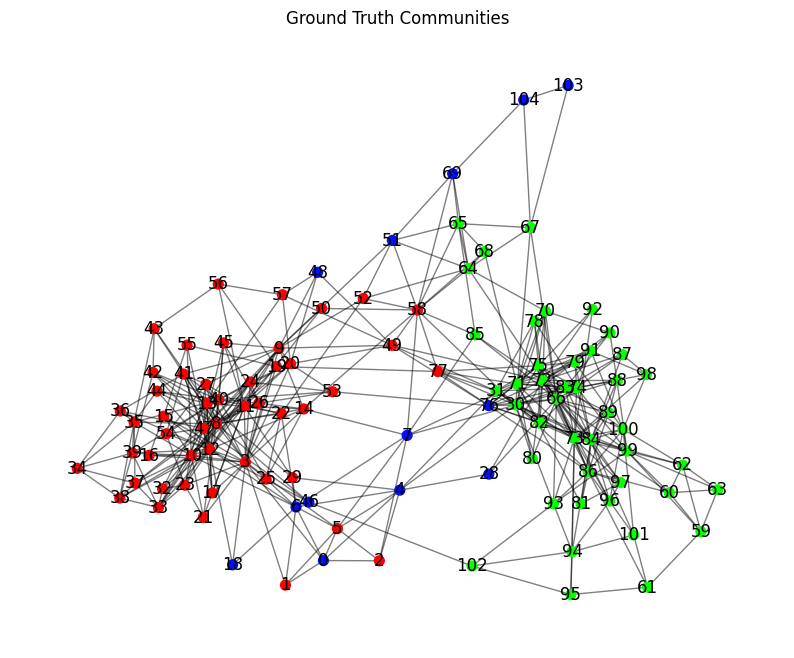

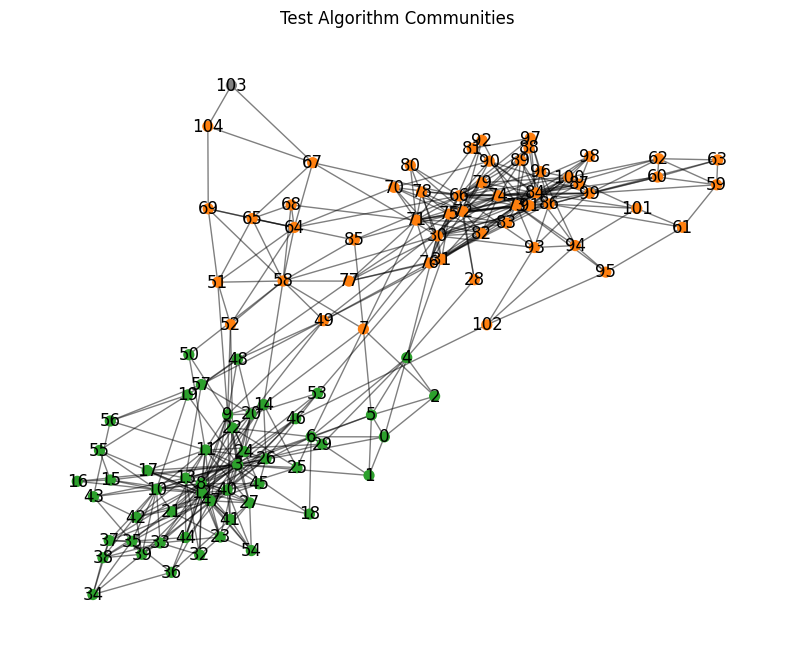

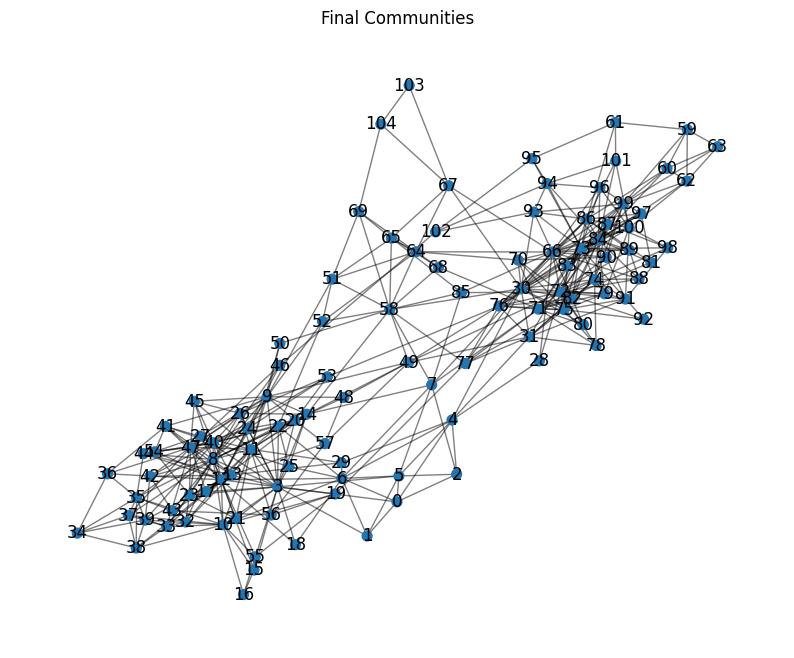

--------------------Adjacency Matrix------------------
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
-----------------Jaccard Matrix---------------
[[0.         0.42857143 0.25       ... 0.         0.         0.        ]
 [0.42857143 0.         0.33333333 ... 0.         0.         0.        ]
 [0.25       0.33333333 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.25      ]
 [0.         0.         0.         ... 0.         0.25       0.        ]]
---------------------Normalized Jaccard Matrix------------------
[[0.         0.09301272 0.05425742 ... 0.         0.         0.        ]
 [0.09512563 0.         0.0739866  ... 0.         0.         0.        ]
 [0.1003561  0.13380813 0.         ... 0.         0.         0.        ]
 ...
 [0.     

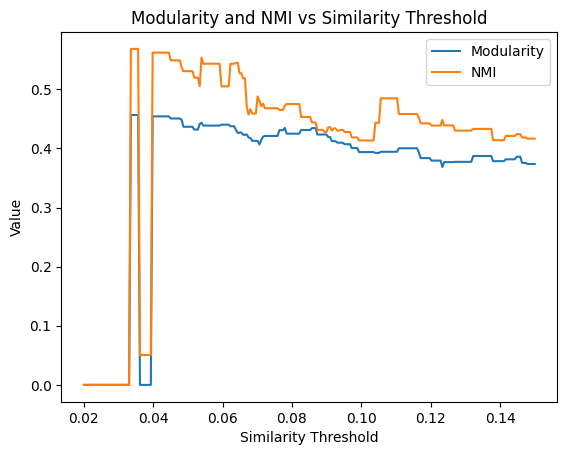

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
import urllib.request
import io
import zipfile
import copy


def merge_small_communities(G, initial_communities, similarityy_threshold=0.5):
    # Convert initial communities to sets
    initial_communities = [set(c) for c in initial_communities]

    # Initialize large communities
    large_communities = []

    # Iterate over each small community
    for small_community in initial_communities:
        best_total_similarity = 0
        best_large_community_index = None
        best_average_similarity = 0

        # Iterate over existing large communities
        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            total_pairs = 0

            # Calculate total similarity between small and large communities
            for node in small_community:
                for neighbor in G.neighbors(node):
                    if neighbor in large_community:
                        n_u = set(G.neighbors(node)) | {node}
                        n_v = set(G.neighbors(neighbor)) | {neighbor}
                        intersection = len(n_u & n_v)
                        union = len(n_u | n_v)
                        similarity = float(intersection) / union if union != 0 else 0
                        total_similarity += similarity
                        total_pairs += 1

            # Calculate average similarity
            if total_pairs != 0:
                average_similarity = total_similarity / total_pairs
            else:
                average_similarity = 0

            # Update best community if average similarity exceeds threshold
            if average_similarity > best_average_similarity:
                best_average_similarity = average_similarity
                best_large_community_index = i

        # Merge small community into best matching large community
        if best_large_community_index is not None and best_average_similarity >= similarityy_threshold:
            large_communities[best_large_community_index] = large_communities[best_large_community_index].union(small_community)
        else:
            large_communities.append(small_community)

    # Convert sets back to lists
    final_communities = [list(community) for community in large_communities]

    return final_communities

def find_most_similar_node_pairs_iterative(similarity_matrix):
    current_similarity_matrix = copy.deepcopy(similarity_matrix)
    num_nodes = current_similarity_matrix.shape[0]

    # Initialize a dictionary to store results based on similarity values
    similar_pairs_dict = {}
    s = set()
    while (len(s) < num_nodes):
        # Find the indices of the maximum similarity value in the entire matrix
        i, j = np.unravel_index(np.argmax(current_similarity_matrix, axis=None), current_similarity_matrix.shape)
        similar_pair = (i, j)
        s.add(i)
        s.add(j)
        similar_value = current_similarity_matrix[i, j]

        # Exclude the current pair by setting its similarity to -inf
        current_similarity_matrix[i, j] = -np.inf

        # Append the result to the dictionary based on similarity value
        if similar_value not in similar_pairs_dict:
            similar_pairs_dict[similar_value] = []

        similar_pairs_dict[similar_value].append(similar_pair)

    # # # Print and return the results
    # for value, pairs in similar_pairs_dict.items():
    #     for idx, pair in enumerate(pairs):
    #          print(f"Similar Pair with Value {value}, Index {idx + 1}: {pair}")

    return similar_pairs_dict





def form_initial_communities(result_matrix, lambda_threshold=2, similarity_threshold=0.145):
    num_nodes = result_matrix.shape[0]
    communities = [[node] for node in range(num_nodes)]  # Initially, each node is in its own community

    # Create a new similarity matrix with updated values
    updated_similarity_matrix = result_matrix.copy()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if result_matrix[i, j] < similarity_threshold:
                updated_similarity_matrix[i, j] = 0

    # Print the new similarity matrix
    # print("New Similarity Matrix:")
    # for row in updated_similarity_matrix:
    #     print(list(row))

    while True:
        # Find the pair of communities with the highest average similarity score
        max_avg_similarity = 0
        max_community_pair = None

        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                community_i = communities[i]
                community_j = communities[j]

                total_similarity = 0
                num_nodes_i = len(community_i)

                for u in community_i:
                    node_similarity_sum = sum(updated_similarity_matrix[u, v] for v in community_j)
                    node_avg_similarity = node_similarity_sum / len(community_j)
                    total_similarity += node_avg_similarity
                total_similarity /= num_nodes_i

                if total_similarity > max_avg_similarity:
                    max_avg_similarity = total_similarity
                    max_community_pair = (i, j)


        if max_community_pair is None:
            break  # No more communities to merge

        if max_avg_similarity < similarity_threshold:
                    break
        # Merge the communities with the highest average similarity score
        i, j = max_community_pair
        merged_community = communities[i] + communities[j]
        communities.pop(j)
        communities.pop(i)
        communities.append(merged_community)

        # Check if all remaining communities have at least the specified threshold
        if min(len(community) for community in communities) >= lambda_threshold:
            break

    return communities


def matrix_operation(A, S, G):  # Assuming G is your graph
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    n = num_edges / num_nodes  # Calculate n as the number of nodes divided by the number of edges

    # Calculate S^n
    S_power_n = np.linalg.matrix_power(S, int(n))

    # Perform A * S^n
    result = np.dot(A, S_power_n)
    # print("---------------------Steady State Matrix------------------")
    # print(result)

    return result


def normalized_coefficients(jaccard_matrix):
    # Initialize an empty matrix of the same shape as the jaccard_matrix
    normalized_matrix = np.zeros(jaccard_matrix.shape)

    # Iterate over each row in the jaccard_matrix
    for i in range(jaccard_matrix.shape[0]):
        row_sum = np.sum(jaccard_matrix[i, :])  # Calculate the sum of the current row
        if row_sum > 0:  # Avoid division by zero'
            normalized_matrix[i, :] = jaccard_matrix[i, :] / row_sum
            nsum = np.sum(normalized_matrix[i, :])  # Normalize the row by its sum
    # checks if the sum of each row is 1
    # for i in range(normalized_matrix.shape[0]):
    #     row_sum = np.sum(normalized_matrix[i, :])
    #     print(f"Sum of row {i}: {row_sum}")
    print("---------------------Normalized Jaccard Matrix------------------")
    print(normalized_matrix)
    return normalized_matrix


def get_jaccard_coefficients(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v:  # Ensure we're not comparing a node with itself
                n_u = set(G[u])  # Neighbors of u
                n_v = set(G[v])  # Neighbors of v
                intersection = len(n_u & n_v)
                union = len(n_u | n_v)
                adjacency_matrix[u, v] = float(intersection) / (union) if union != 0 else 0
    print("-----------------Jaccard Matrix---------------")
    print(adjacency_matrix)
    return adjacency_matrix


def get_adjacency_matrix(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if G.has_edge(i, j):
                adjacency_matrix[i, j] = 1
            else:
                adjacency_matrix[i, j] = 0
    print("--------------------Adjacency Matrix------------------")
    print(adjacency_matrix)
    return adjacency_matrix


url = "https://websites.umich.edu/~mejn/netdata/polbooks.zip"

sock = urllib.request.urlopen(url)
s = io.BytesIO(sock.read())
sock.close()

zf = zipfile.ZipFile(s)
gml = zf.read("polbooks.gml").decode()

# Parse GML data
gml = gml.split("\n")[1:]
G = nx.parse_gml('\n'.join(gml))

# Convert node labels to integers
mapping = dict(zip(G.nodes(), range(len(G.nodes()))))
G = nx.relabel_nodes(G, mapping)

print(G.nodes())
print(G.edges())



books_truth = [2,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,
              0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,1,1,1,1,1,1,1,
              1,1,1,2,1,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,1,1,
              1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2]





Adjancency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)
# print(A)
print(jaccard_coefficients)
print(jaccard_normalized)
# Optionally, print the Jaccard coefficients
markov_similarity_enhancement_matrix = matrix_operation(Adjancency, jaccard_normalized, G)
print(markov_similarity_enhancement_matrix)
result_list = find_most_similar_node_pairs_iterative(markov_similarity_enhancement_matrix)

initial_communities = form_initial_communities(markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.033)
final_communities = merge_small_communities(G, initial_communities,similarityy_threshold=0.05)

print("----------------------------Initial Community----------------------------------")
for i, community in enumerate(initial_communities):
    print(f"Community {i + 1}: {community}")

print("-----------------------------Final Community-----------------------------------")
for i, community in enumerate(final_communities):
    print(f"Final Community {i + 1}: {community}")


def create_sets_based_on_membership(G, books_truth):
    membership_sets = {}  # Dictionary to store sets of nodes for each ground truth membership

    for node, membership in enumerate(books_truth):
        if membership not in membership_sets:
            membership_sets[membership] = set()

        membership_sets[membership].add(node)

    return membership_sets

# # Create sets based on ground truth membership
membership_sets = create_sets_based_on_membership(G, books_truth)

print("------------------------Sets based on Ground Truth Membership-------------------")
for membership, node_set in membership_sets.items():
     print(f"Ground Truth Membership: {membership}, Nodes: {node_set}")


print("Modularity",nx.community.quality.modularity(G, final_communities))

num_nodes = G.number_of_nodes()


predicted_labels = np.zeros(num_nodes, dtype=int)
for idx, community in enumerate(final_communities):
    for node in community:
        predicted_labels[node] = idx
print("Predicted Labels:", predicted_labels)
print(books_truth)
nmi_score_binary_matrix = normalized_mutual_info_score(books_truth, predicted_labels)

print("NMI Score", nmi_score_binary_matrix)

def plot_communities(G, communities, title):
    # Manually define a list of colors for the communities
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf","#00b2fe","#39D2C0"
    ]
    # This list can be extended with more colors if needed

    # Assign a color to each community, grey for communities of size 1
    community_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if len(community) == 1:
                community_colors[node] = "grey"  # Grey color for communities of size 1
            else:
                # Use modulo to cycle through the color list if there are more communities than colors
                community_colors[node] = colors[i % len(colors)]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[community_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_groundtruth_communities(G, membership_sets):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)

    # Assign a color to each ground truth membership
    membership_colors = {node: color_map(membership) for membership, nodes in membership_sets.items() for node in nodes}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[membership_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title("Ground Truth Communities")
    plt.axis('off')
    plt.show()
# Example usage:
# Plot the initial communities
membership_sets = create_sets_based_on_membership(G, books_truth)

# Plot the ground truth communities
plot_groundtruth_communities(G, membership_sets)

plot_communities(G, initial_communities, "Test Algorithm Communities")
#plot_communities(G, membership_sets, "Groundtruth Communites")
# Plot the final communities
plot_communities(G, final_communities, "Final Communities")

similarity_thresholds = np.linspace(0.02, 0.15, 250)  # Adjust range and steps as needed
modularity_values = []
nmi_values = []

Adjacency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)

# Iterate over similarity thresholds
for similarity_threshold in similarity_thresholds:
    # Enhance similarity matrix and find communities

    markov_similarity_enhancement_matrix = matrix_operation(Adjacency, jaccard_normalized, G)
    initial_communities = form_initial_communities(markov_similarity_enhancement_matrix, lambda_threshold=2, similarity_threshold=similarity_threshold)
    final_communities = merge_small_communities(G, initial_communities, similarityy_threshold = 0.03)

    # Calculate modularity
    modularity = nx.community.quality.modularity(G, final_communities)
    modularity_values.append(modularity)

    # Calculate NMI
    predicted_labels = np.zeros(G.number_of_nodes(), dtype=int)
    for idx, community in enumerate(final_communities):
        for node in community:
            predicted_labels[node] = idx
    nmi = normalized_mutual_info_score(books_truth , predicted_labels)
    nmi_values.append(nmi)

max_modularity_index = np.argmax(modularity_values)
max_nmi_index = np.argmax(nmi_values)

# Corresponding similarity thresholds
similarity_threshold_with_max_modularity = similarity_thresholds[max_modularity_index]
similarity_threshold_with_max_nmi = similarity_thresholds[max_nmi_index]

# Maximum modularity and NMI values
max_modularity = modularity_values[max_modularity_index]
max_nmi = nmi_values[max_nmi_index]

print("Maximum Modularity:")
print("Similarity Threshold:", similarity_threshold_with_max_modularity)
print("Modularity:", max_modularity)

print("\nMaximum NMI:")
print("Similarity Threshold:", similarity_threshold_with_max_nmi)
print("NMI:", max_nmi)

# Plot both Modularity and NMI values against similarity thresholds
plt.plot(similarity_thresholds, modularity_values, label='Modularity')
plt.plot(similarity_thresholds, nmi_values, label='NMI')
plt.title('Modularity and NMI vs Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()